*Kernel density estimation(KDE)* is in some senses an algorithm which takes the mixture-of-Gaussians idea to its logical extreme: it uses a mixture consisting of one Gaussian component *per point*, resulting in an essentially non-parametric estimator of density

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

# Motivating KDE: Histograms

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

x = make_data(1000)

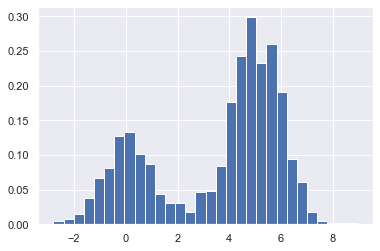

In [3]:
hist = plt.hist(x, bins=30, density=True)

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

This normalization is chosen so that the total area under the histogram is equal to 1

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

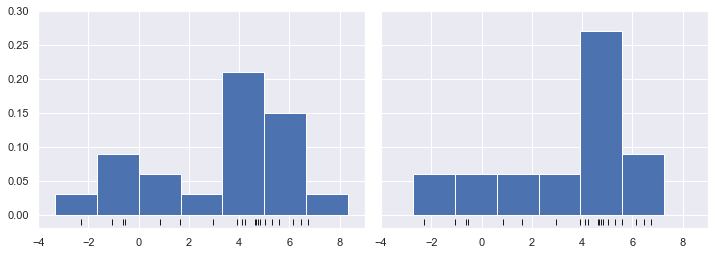

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                       sharex=True, sharey=True,
                       subplot_kw={'xlim': (-4, 9),
                                   'ylim': (-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

On the left, the histogram makes clear that this is a bimodal distribution. On the right, we see unimodal distribution with a long tail. <br>
Without seeing the preceding code, you would probably not guess that these two histograms were build from the same data: with that in mind, how can you trust the intuitin that histogram confer? And how might we improve on this?

(-0.2, 8)

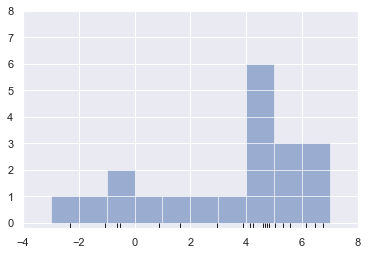

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
        
ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)

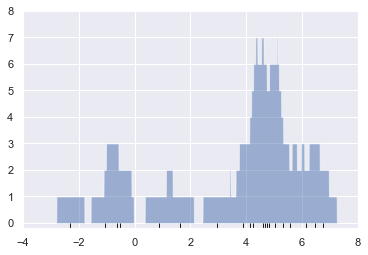

In [8]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

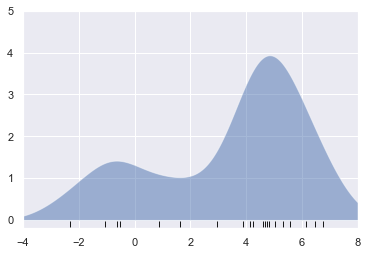

In [9]:
from scipy.stats import norm
x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

# Kernel Density Estimation in Practice

(-0.02, 0.22)

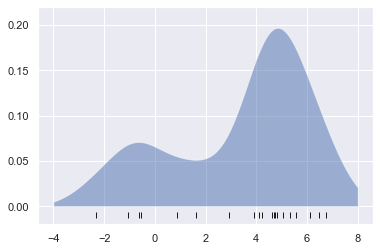

In [10]:
from sklearn.neighbors import KernelDensity

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

## Selecting the bandwidth via cross-validation <br>

The choice of bandwidth within KDE is extremely important to finding a suitable density estimate:

- too narrow a bandwidth leads to a high-variance estimate(i.e., over-fitting), too wide a bandwidth leads to a high-bias estimate (i.e., under-fitting) <br>

In machine learning context, we've seen that such hyperparameter tunning often is done empirically via a cross-validation approach

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                    {'bandwidth': bandwidths},
                    cv=LeaveOneOut())
grid.fit(x[:, None]);

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

# Example: KDE on a Sphere

In [13]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

# Get matrices/arrays of species IDs and Locations
latlon = np.vstack([data.train['dd lat'], data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                    for d in data.train['species']], dtype='int')

C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


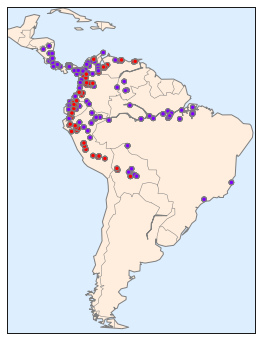

In [14]:
import os
os.environ['PROJ_LIB'] = 'C:\\Users\\imdff\\Anaconda3\\Library\\share'
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids

xgrid, ygrid = construct_grids(data)

# plot coastlines with basemap
plt.figure(figsize=(10, 6))
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
            llcrnrlon=xgrid.min(), urcrnrlon=xgrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

# plot locations
m.scatter(latlon[:, 1], latlon[:, 0], zorder=3, s=20, edgecolor='gray', lw=1,
          c=species, cmap='rainbow', latlon=True);

This doesn;t give us a very good idea of the density of the species, because points in the species range may overlap one another <br><br>

Let's use kernel density estimation to show this distribution in a more interpretable way

C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\imdff\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


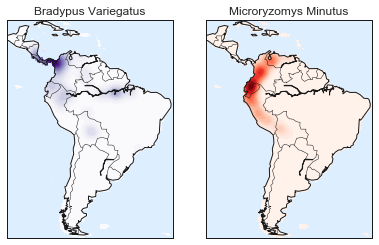

In [15]:
# Set up the data grid for the contour plot
X, Y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([Y.ravel(), X.ravel()]).T
xy = np.radians(xy[land_mask])

# Create two side-by-side plots
fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    
    # plot coastlines with basemap
    m = Basemap(projection='cyl', llcrnrlat=Y.min(),
                urcrnrlat=Y.max(), llcrnrlon=X.min(),
                urcrnrlon=X.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    # construct a shperical kernel density estimate of the distribution
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    # evaluate only on the land: -9999 indicates ocean
    Z = np.full(land_mask.shape[0], -9999.0)
    Z[land_mask] = np.exp(kde.score_samples(xy))
    Z = Z.reshape(X.shape)
    
    # plot contours of the density
    levels = np.linspace(0, Z.max(), 25)
    axi.contourf(X, Y, Z, levels=levels, cmap=cmaps[i])

# Example: Not-So-Naive Bayes <br>

For Gaussian naive Bayes, the generative model is a simple axis-aligned Gaussian. With a density estimation algorithm like KDE, we can remove the "naive" element and perform the same classification with a more sophisticated generative model for each class. It's still Bayesian classification, but it's no longer naive. <br><br>

The general approach for generative classification is this:
1. Split the training data by label
2. For each set, fit a KDE to obtain a generative model of data. This allows you for any observation $x$ and label $y$ to compute a likelihodd $P(x|y)$.
3. From the number of examples of each class in the training set, compute the class prior, $P(y)$.
4. For an unknown point $x$, the posterior probability for each class is $P(y|x) = P(x|y)P(y)$. The class which maximizes this posterior is the label assigned to the point.

In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin

class KDEClassifier(BaseEstimator, ClassifierMixin):
    """Bayesian generative classification based on KDE
    
    Parameters
    ----------
    bandwidth : float
        the kernel bandwidth within each class
    kernel : str
        the kernel name, passwd to KernelDensity
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                      kernel=self.kernel).fit(Xi)
                        for Xi in training_sets]
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                           for Xi in training_sets]
        
        return self
    
    def predict_proba(self, X):
        logprobs = np.array([model.score_samples(X)
                             for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):
        return self.classes_[np.argmax(self.predict_proba(X), 1)]

## Using our cutom estimator

In [17]:
from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0, 2, 100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth': bandwidths})
grid.fit(digits.data, digits.target)

scores = [val.mean_validation_score for val in grid.grid_scores_]

C:\Users\imdff\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

In [30]:
print(grid.best_params_)
print('accuracy =', grid.best_score_)

{'bandwidth': 7.054802310718643}
accuracy = 0.9666110183639399


In [31]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

C:\Users\imdff\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.8186003803550138

Imrovements that could be made to our KDE classifier model:

- we could allow that the bandwidth in each class to vary independently
- we could optimize these bandwidths not based on their prediction score, but on the likelihood of the training data under the generative model widthin each class(i.e. use the scores from `KernelDensity` itself rather than the global prediction accuracy)